In [75]:
# TODO: Three different current profiles can be computed by changing the values of `direction` in the next cell to:
# 
# - 'left-right'
# - 'left-top'
# - 'top-right'

direction = 'top-right'

## Generate mesh with `gmsh`

In [76]:
import gmsh
import numpy as np

dim = 3
lc = 2

gmsh.initialize()

In [77]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc*0.8)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)

In [78]:
step = 300

ly = 100
lx = 2*step

lz = 30
wedge_y = 25
wedge_x = 30
step_yp = 200
ey = ly + step_yp

In [79]:
points = [
    gmsh.model.geo.add_point(0, 0, 0, lc),
    
    gmsh.model.geo.add_point(lx, 0, 0, lc),
    gmsh.model.geo.add_point(lx, ly, 0, lc),
    
    gmsh.model.geo.add_point(step + ly/2 + wedge_x, ly, 0, lc),
    gmsh.model.geo.add_point(step + ly/2, ly - wedge_x, 0, lc),
    gmsh.model.geo.add_point(step + ly/2 - wedge_y, ly, 0, lc),
    gmsh.model.geo.add_point(step + ly/2, ly + wedge_y, 0, lc),
    
    
    gmsh.model.geo.add_point(step + ly/2, ey, 0, lc),
    gmsh.model.geo.add_point(step - ly/2, ey, 0, lc),
    
    gmsh.model.geo.add_point(step - ly/2, ly + wedge_y, 0, lc),
    gmsh.model.geo.add_point(step - ly/2 + wedge_y, ly, 0, lc),
    gmsh.model.geo.add_point(step - ly/2, ly - wedge_x, 0, lc),
    gmsh.model.geo.add_point(step - ly/2 - wedge_x, ly, 0, lc),
    
    gmsh.model.geo.add_point(0, ly, 0, lc),
]

In [80]:
lines = [gmsh.model.geo.add_line(p1, p2) for p1, p2 in zip(points[:-1], points[1:])] + [gmsh.model.geo.add_line(points[-1], points[0])]

In [81]:
sl = gmsh.model.geo.add_curve_loop(lines)

In [82]:
surface = gmsh.model.geo.add_plane_surface([sl])

In [83]:
vol = gmsh.model.geo.extrude([(2, surface)], 0, 0, lz, [lz / lc], [1])
vol

[(2, 86),
 (3, 1),
 (2, 33),
 (2, 37),
 (2, 41),
 (2, 45),
 (2, 49),
 (2, 53),
 (2, 57),
 (2, 61),
 (2, 65),
 (2, 69),
 (2, 73),
 (2, 77),
 (2, 81),
 (2, 85)]

In [84]:
gmsh.model.geo.synchronize()
gmsh.model.add_physical_group(dim=dim, tags=[1])
gmsh.model.mesh.generate(dim)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 16 (Extruded)
Info    : [ 40%] Meshing curve 17 (Extruded)
Info    : [ 40%] Meshing curve 18 (Extruded)
Info    : [ 50%] Meshing curve 19 (Extruded)
Info    : [ 50%] Meshing curve 20 (Extruded)
Info    : [ 50%] Meshing curve 21 (Extruded)
Info    : [ 50%] Meshing curve 22 (Extruded)
Info    : [ 50%] Meshing curve 23 (Extruded)
Info    : [ 60%] Meshing curve 24 (Extruded)
Info  

## Import mesh into `dolfinx`

In [85]:
import dolfinx.io as io
from mpi4py import MPI

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
mesh, cell_markers, facet_markers = io.gmshio.model_to_mesh(gmsh.model,
                                                            mesh_comm,
                                                            gmsh_model_rank,
                                                            gdim=dim)
gmsh.finalize()

In [86]:
import pyvista as pv
from dolfinx import plot
grid = pv.UnstructuredGrid(*plot.create_vtk_mesh(mesh, mesh.topology.dim))

## Create function space for trial and test functions

In [87]:
import dolfinx.fem as fem
import ufl

from petsc4py.PETSc import ScalarType

V = fem.FunctionSpace(mesh, ("CG", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

## Set Neumann boundary conditions

In [88]:
import dolfinx

In [89]:
left = lambda x: np.isclose(x[0], 0)
right = lambda x: np.isclose(x[0], lx)
top = lambda x: np.isclose(x[1], ey)

In [90]:
if direction == 'left-right':
    bc1 = left
    bc2 = right
    bc3 = lambda x: np.logical_not(np.logical_or(left(x), right(x)))
elif direction == 'left-top':
    bc1 = left
    bc2 = top
    bc3 = lambda x: np.logical_not(np.logical_or(left(x), top(x)))
elif direction == 'top-right':
    bc1 = top
    bc2 = right
    bc3 = lambda x: np.logical_not(np.logical_or(top(x), right(x)))
else:
    raise ValueError(f'Invalid value for {direction=}')

In [91]:
boundaries_x = [(1, bc1), (2, bc2), (3, bc3)]
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for marker, locator in boundaries_x:
    facets = dolfinx.mesh.locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = dolfinx.mesh.meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [92]:
ds_new = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)

In [93]:
f = fem.Constant(mesh, ScalarType(0))
nmbc_1 = fem.Constant(mesh, ScalarType(-1e12))
nmbc_2 = fem.Constant(mesh, ScalarType(1e12))

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx - nmbc_1 * v * ds_new(1) - nmbc_2 * v * ds_new(2) - f * v * ds_new(3)

In [94]:
problem = fem.petsc.LinearProblem(a, L)
v_field = problem.solve()

### Solve for j

In [95]:
W_new = fem.VectorFunctionSpace(mesh=mesh, dim=3, element=("CG", 1))
u_new = ufl.TrialFunction(W_new)
v_new = ufl.TestFunction(W_new)

LHS = ufl.dot(u_new, v_new) * ufl.dx
RHS = ufl.dot(-ufl.grad(v_field), v_new) * ufl.dx

In [96]:
problem_new = fem.petsc.LinearProblem(LHS, RHS)
j_new = problem_new.solve()

In [97]:
grid.point_data["j"] = j_new.x.array.reshape((-1, 3))

### Ouput `j_new`

In [98]:
import dolfinx

In [99]:
n = (round(lx / 2.5), round((ey) / 2.5), round(lz / 2.5))
n

(240, 120, 12)

In [100]:
drmesh = dolfinx.mesh.create_box(mesh_comm, points=((0, 0, 0), (lx, ey, lz)), n=n, cell_type=dolfinx.mesh.CellType.hexahedron)

In [101]:
W_dg = fem.VectorFunctionSpace(mesh=drmesh, dim=3, element=("DG", 0))
function = dolfinx.fem.Function(W_dg)
function.interpolate(j_new)

In [102]:
drgrid = pv.UnstructuredGrid(*plot.create_vtk_mesh(drmesh, drmesh.topology.dim))

In [103]:
drgrid['j'] = function.x.array.reshape((-1, 3))

---

In [104]:
import discretisedfield as df

In [105]:
fmesh = df.Mesh(p1=(0, 0, 0), p2=(lx, ey, lz), n=n)

In [106]:
rgrid = pv.RectilinearGrid(fmesh.points.x, fmesh.points.y, fmesh.points.z)

In [107]:
j_field = df.Field(fmesh, nvdim=3, value=rgrid.sample(drgrid)['j'].reshape((*reversed(n), 3)).swapaxes(0, 2), valid='norm')

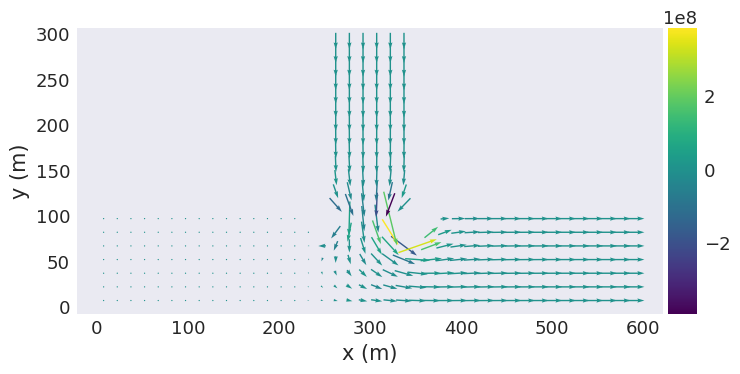

In [108]:
j_field.sel('z').resample((40, 20)).mpl.vector()

In [109]:
import matplotlib.pyplot as plt

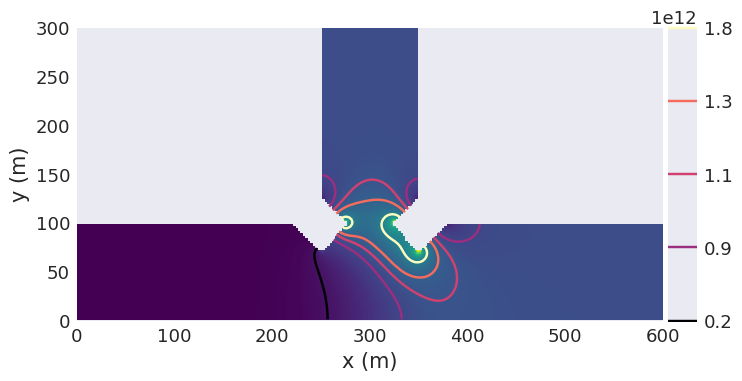

In [110]:
fig, ax = plt.subplots()
j_field.sel('z').norm.mpl(ax=ax, scalar_kw=dict(colorbar=False))

j_field.sel('z').norm.mpl.contour(filter_field=j_field.sel('z').norm, ax=ax, cmap='magma', levels=[0.2e12, .9e12, 1.1e12, 1.3e12, 1.8e12])

In [111]:
j_field.to_file(f'current-{direction}.omf')